# Introduction to GPM-API

In this tutorial, we will provide the foundations to use GPM-API to download, manipulate and analyze data from the Global Precipitation Measurement (GPM) spaceborne radars.


Please note that GPM-API also enable access and analysis tools for the entire GPM constellation of passive microwave sensors as well as the IMERG precipitation products.
For detailed information and additional tutorials, please refer to the [official GPM-API documentation](https://gpm-api.readthedocs.io/en/latest/).


First, let's import the package required in this tutorial.

In [1]:
import datetime
import gpm
import numpy as np
import ximage # noqa
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from gpm.utils.geospatial import (
    get_country_extent,
    get_geographic_extent_around_point,
    get_circle_coordinates_around_point,
)
from gpm.utils.gv import volume_matching

Using the `available_products` function, users can obtain a list of all GPM products that can be downloaded and opened into CF-compliant xarray datasets.

In [2]:
gpm.available_products(product_types="RS")  # research products

['1A-GMI',
 '1A-TMI',
 '1B-GMI',
 '1B-Ka',
 '1B-Ku',
 '1B-PR',
 '1B-TMI',
 '1C-AMSR2-GCOMW1',
 '1C-AMSRE-AQUA',
 '1C-AMSUB-NOAA15',
 '1C-AMSUB-NOAA16',
 '1C-AMSUB-NOAA17',
 '1C-ATMS-NOAA20',
 '1C-ATMS-NOAA21',
 '1C-ATMS-NPP',
 '1C-GMI',
 '1C-GMI-R',
 '1C-MHS-METOPA',
 '1C-MHS-METOPB',
 '1C-MHS-METOPC',
 '1C-MHS-NOAA18',
 '1C-MHS-NOAA19',
 '1C-SAPHIR-MT1',
 '1C-SSMI-F08',
 '1C-SSMI-F10',
 '1C-SSMI-F11',
 '1C-SSMI-F13',
 '1C-SSMI-F14',
 '1C-SSMI-F15',
 '1C-SSMIS-F16',
 '1C-SSMIS-F17',
 '1C-SSMIS-F18',
 '1C-SSMIS-F19',
 '1C-TMI',
 '2A-AMSR2-GCOMW1',
 '2A-AMSR2-GCOMW1-CLIM',
 '2A-AMSRE-AQUA-CLIM',
 '2A-AMSUB-NOAA15-CLIM',
 '2A-AMSUB-NOAA16-CLIM',
 '2A-AMSUB-NOAA17-CLIM',
 '2A-ATMS-NOAA20',
 '2A-ATMS-NOAA20-CLIM',
 '2A-ATMS-NOAA21',
 '2A-ATMS-NOAA21-CLIM',
 '2A-ATMS-NPP',
 '2A-ATMS-NPP-CLIM',
 '2A-DPR',
 '2A-ENV-DPR',
 '2A-ENV-Ka',
 '2A-ENV-Ku',
 '2A-ENV-PR',
 '2A-GMI',
 '2A-GMI-CLIM',
 '2A-GPM-SLH',
 '2A-Ka',
 '2A-Ku',
 '2A-MHS-METOPA',
 '2A-MHS-METOPA-CLIM',
 '2A-MHS-METOPB',
 '2A-MHS-MET

Let's have a look at the available RADAR products:

In [3]:
gpm.available_products(product_categories="RADAR", product_levels="1B")

['1B-Ka', '1B-Ku', '1B-PR']

In [4]:
gpm.available_products(product_categories="RADAR", product_levels="2A")

['2A-DPR',
 '2A-ENV-DPR',
 '2A-ENV-Ka',
 '2A-ENV-Ku',
 '2A-ENV-PR',
 '2A-GPM-SLH',
 '2A-Ka',
 '2A-Ku',
 '2A-PR',
 '2A-TRMM-SLH']

In this tutorial, we will use the `2A-DPR` product which provides the GPM Dual-frequency Precipitation Radar (DPR) reflectivities and associated precipitation retrievals. 

Since we are running this tutorial on a Binder environment, we will not execute the following `gpm.download` and `gpm.open_dataset` sections, and directly load the `2A.GPM.DPR.V9-20211125.20230820-S213941-E231213.053847.V07B.HDF5` granule file,  
which has been preconverted to a Zarr Store and uploaded on the Pythia Cloud Bucket to simplify access to the data.

## 1. Download Data

Now let's download the 2A-DPR product over a couple of hours.

To download GPM data with GPM-API, you have to previously create a [NASA Earthdata](https://urs.earthdata.nasa.gov/) and/or [NASA PPS](https://registration.pps.eosdis.nasa.gov/registration/) account.
We provide a step-by-step guide on how to set up your accounts in the [official GPM-API documentation](https://gpm-api.readthedocs.io/en/latest/03_quickstart.html).

In [394]:
# Specify the time period you are interested in
start_time = datetime.datetime.strptime("2023-08-20 22:12:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2023-08-20 22:13:45", "%Y-%m-%d %H:%M:%S")
# Specify the product and product type
product = "2A-DPR"  # 2A-PR
product_type = "RS"
storage = "GES_DISC"
# Specify the version
version = 7

In [395]:
# Download the data
gpm.download(
    product=product,
    product_type=product_type,
    version=version,
    start_time=start_time,
    end_time=end_time,
    storage=storage,
    force_download=False,
    verbose=True,
    progress_bar=True,
    check_integrity=False,
)

All the available GPM 2A-DPR product files are already on disk.


Once, the data are downloaded on disk, let's load the 2A-DPR product and look at the dataset structure.

## 2. Load Data

With GPM-API, the name granule is used to refer to a single file, while the name dataset is used to refer to a collection of granules.

GPM-API enables to open single or multiple granules into an xarray.Dataset, an object designed for working with labeled multi-dimensional arrays.

- The `gpm.open_granule(filepath)` opens a single file into xarray by providing the path of the file of interest.

- The `gpm.open_dataset` function enables to open a collection of granules over a period of interest.

In [396]:
# Load the 2A-DPR dataset
ds = gpm.open_dataset(
    product=product,
    product_type=product_type,
    version=version,
    start_time=start_time,
    end_time=end_time,
)
ds

'scan_mode' has not been specified. Default to FS.


<xarray.Dataset> Size: 100MB
Dimensions:                       (cross_track: 49, along_track: 151,
                                   nfreqHI: 3, range: 176, nNode: 5,
                                   nbinSZP: 7, radar_frequency: 2, nNUBF: 3,
                                   method: 6, three: 3, foreBack: 2,
                                   nearFar: 2, nsdew: 3, four: 4, nNP: 4,
                                   XYZ: 3, DSD_params: 2)
Coordinates: (12/16)
    sunLocalTime                  (cross_track, along_track) float32 30kB dask.array<chunksize=(49, 151), meta=np.ndarray>
    height                        (cross_track, along_track, range) float32 5MB dask.array<chunksize=(49, 151, 176), meta=np.ndarray>
    dataQuality                   (along_track, radar_frequency) float32 1kB dask.array<chunksize=(151, 2), meta=np.ndarray>
    SCorientation                 (along_track) float32 604B dask.array<chunksize=(151,), meta=np.ndarray>
    lon                           (cross_track, along_track) float32 30kB -12...
    lat                           (cross_track, along_track) float32 30kB 32....
    ...                            ...
    gpm_along_track_id            (along_track) int64 1kB ...
  * range                         (range) int64 1kB 1 2 3 4 ... 173 174 175 176
    gpm_range_id                  (range) int64 1kB ...
  * radar_frequency               (radar_frequency) <U2 16B 'Ku' 'Ka'
  * DSD_params                    (DSD_params) <U2 16B 'Nw' 'Dm'
    crsWGS84                      int64 8B 0
Dimensions without coordinates: cross_track, along_track, nfreqHI, nNode,
                                nbinSZP, nNUBF, method, three, foreBack,
                                nearFar, nsdew, four, nNP, XYZ
Data variables: (12/139)
    flagBB                        (cross_track, along_track) float64 59kB dask.array<chunksize=(49, 151), meta=np.ndarray>
    binBBPeak                     (cross_track, along_track) float32 30kB dask.array<chunksize=(49, 151), meta=np.ndarray>
    binBBTop                      (cross_track, along_track) float32 30kB dask.array<chunksize=(49, 151), meta=np.ndarray>
    binDFRmMLBottom               (cross_track, along_track) float32 30kB dask.array<chunksize=(49, 151), meta=np.ndarray>
    binDFRmMLTop                  (cross_track, along_track) float32 30kB dask.array<chunksize=(49, 151), meta=np.ndarray>
    binBBBottom                   (cross_track, along_track) float32 30kB dask.array<chunksize=(49, 151), meta=np.ndarray>
    ...                            ...
    precipWaterIntegrated_Liquid  (cross_track, along_track) float32 30kB dask.array<chunksize=(49, 151), meta=np.ndarray>
    precipWaterIntegrated_Solid   (cross_track, along_track) float32 30kB dask.array<chunksize=(49, 151), meta=np.ndarray>
    precipWaterIntegrated         (cross_track, along_track) float32 30kB dask.array<chunksize=(49, 151), meta=np.ndarray>
    dBNw                          (cross_track, along_track, range) float32 5MB dask.array<chunksize=(49, 151, 176), meta=np.ndarray>
    Dm                            (cross_track, along_track, range) float32 5MB dask.array<chunksize=(49, 151, 176), meta=np.ndarray>
    Nw                            (cross_track, along_track, range) float32 5MB dask.array<chunksize=(49, 151, 176), meta=np.ndarray>
Attributes: (12/23)
    FileName:              2A.GPM.DPR.V9-20211125.20230820-S213941-E231213.05...
    EphemerisFileName:     
    AttitudeFileName:      
    TotalQualityCode:      Good
    DielectricFactorKa:    0.8989
    DielectricFactorKu:    0.9255
    ...                    ...
    DataFormatVersion:     7h
    MetadataVersion:       7h
    ProcessingMode:        STD
    ScanMode:              FS
    history:               Created by ghiggi/gpm_api software on 2024-08-22 1...
    gpm_api_product:       2A-DPR

Here we directly read the data required for this tutorial from the Pythia Cloud Bucket so that you don't have to register a NASA account and download the data beforehand.

In [5]:
filepath_sr = "/home/ghiggi/data/bucket/2A.GPM.DPR.V9-20211125.20230820-S213941-E231213.053847.V07B.zarr"
ds = xr.open_zarr(filepath_sr)
ds

<xarray.Dataset> Size: 6GB
Dimensions:                        (cross_track: 49, along_track: 7932,
                                    range: 176, DSD_params: 2, four: 4,
                                    method: 6, radar_frequency: 2, three: 3,
                                    nfreqHI: 3, nNode: 5, nNUBF: 3, nNP: 4,
                                    foreBack: 2, nearFar: 2, XYZ: 3,
                                    nbinSZP: 7, nsdew: 3)
Coordinates: (12/16)
  * DSD_params                     (DSD_params) <U2 16B 'Nw' 'Dm'
    SCorientation                  (along_track) float32 32kB dask.array<chunksize=(7932,), meta=np.ndarray>
    crsWGS84                       int64 8B ...
    dataQuality                    (along_track, radar_frequency) float32 63kB dask.array<chunksize=(7932, 2), meta=np.ndarray>
    gpm_along_track_id             (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    gpm_cross_track_id             (cross_track) int64 392B dask.array<chunksize=(49,), meta=np.ndarray>
    ...                             ...
    lat                            (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
    lon                            (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
  * radar_frequency                (radar_frequency) <U2 16B 'Ku' 'Ka'
  * range                          (range) int64 1kB 1 2 3 4 ... 173 174 175 176
    sunLocalTime                   (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    time                           (along_track) datetime64[ns] 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
Dimensions without coordinates: cross_track, along_track, four, method, three,
                                nfreqHI, nNode, nNUBF, nNP, foreBack, nearFar,
                                XYZ, nbinSZP, nsdew
Data variables: (12/142)
    DFRforward1                    (cross_track, along_track, range) float32 274MB dask.array<chunksize=(49, 500, 176), meta=np.ndarray>
    Dm                             (cross_track, along_track, range) float32 274MB dask.array<chunksize=(49, 500, 176), meta=np.ndarray>
    FractionalGranuleNumber        (along_track) float64 63kB dask.array<chunksize=(500,), meta=np.ndarray>
    MSindex                        (cross_track, along_track) float64 3MB dask.array<chunksize=(49, 500), meta=np.ndarray>
    MSindexKa                      (cross_track, along_track) float64 3MB dask.array<chunksize=(49, 500), meta=np.ndarray>
    MSindexKu                      (cross_track, along_track) float64 3MB dask.array<chunksize=(49, 500), meta=np.ndarray>
    ...                             ...
    widthBB                        (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    zFactorFinal                   (cross_track, along_track, range, radar_frequency) float32 547MB dask.array<chunksize=(49, 500, 176, 2), meta=np.ndarray>
    zFactorFinalESurface           (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
    zFactorFinalNearSurface        (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
    zFactorMeasured                (cross_track, along_track, range, radar_frequency) float32 547MB dask.array<chunksize=(49, 500, 176, 2), meta=np.ndarray>
    zeta                           (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
Attributes: (12/23)
    AlgorithmID:           2ADPR
    AlgorithmVersion:      9.20211125
    AttitudeFileName:      
    DOI:                   10.5067/GPM/DPR/GPM/2A/07
    DOIauthority:          http://dx.doi.org/
    DataFormatVersion:     7h
    ...                    ...
    ProductVersion:        V07B
    SatelliteName:         GPM
    ScanMode:              FS
    TotalQualityCode

## 3. Basic Manipulations

You can list variables, coordinates and dimensions with the following methods:

In [6]:
# Available variables
print("Available variables: ", list(ds.data_vars))
# Available coordinates
print("Available coordinates: ", list(ds.coords))
# Available dimensions
print("Available dimensions: ", list(ds.dims))
# Spatial dimension: 
print("Spatial dimensions: ", ds.gpm.spatial_dimensions)
# Vertical dimension: 
print("Vertical dimension: ", ds.gpm.vertical_dimension)

Available variables:  ['DFRforward1', 'Dm', 'FractionalGranuleNumber', 'MSindex', 'MSindexKa', 'MSindexKu', 'MSkneeDFRindex', 'MSslopesKa', 'MSslopesKu', 'MSsurfPeakIndexKa', 'MSsurfPeakIndexKu', 'NUBFindex', 'Nw', 'PIAalt', 'PIAdw', 'PIAhb', 'PIAhybrid', 'PIAweight', 'PIAweightHY', 'RFactorAlt', 'acsModeMidScan', 'adjustFactor', 'airTemperature', 'alongTrackBeamWidth', 'attenuationNP', 'binBBBottom', 'binBBPeak', 'binBBTop', 'binClutterFreeBottom', 'binDFRmMLBottom', 'binDFRmMLTop', 'binEchoBottom', 'binHeavyIcePrecipBottom', 'binHeavyIcePrecipTop', 'binMirrorImageL2', 'binMixedPhaseTop', 'binNode', 'binRealSurface', 'binStormTop', 'binZeroDeg', 'binZeroDegSecondary', 'crossTrackBeamWidth', 'dBNw', 'dataWarning', 'dprAlt', 'echoCountRealSurface', 'elevation', 'ellipsoidBinOffset', 'epsilon', 'flagAnvil', 'flagBB', 'flagEcho', 'flagGraupelHail', 'flagHail', 'flagHeavyIcePrecip', 'flagInversion', 'flagMLquality', 'flagPrecip', 'flagSLV', 'flagScanPattern', 'flagSensor', 'flagShallowRain

Through the use of the xarray `gpm` accessor, you can access various methods that simplify for example the listing of variables according to their dimensions.

For example, using `ds.gpm.spatial_3d_variables` you can list all dataset variables with spatial horizontal and vertical dimensions, while with 
`ds.gpm.spatial_2d_variables` you can list all dataset variables with only spatial horizontal dimensions. 

To directly obtain a dataset with the variables of interest, you can also call the `ds.gpm.select_spatial_2d_variables` or `ds.gpm.select_spatial_3d_variables`  methods.

Please keep in mind that to create a spatial map, it is necessary to select spatial 2D variables, while for extracting vertical cross-sections it is necessary to slice across spatial 3D variables.

In [7]:
print(ds.gpm.spatial_2d_variables)
ds.gpm.select_spatial_2d_variables()

['MSindex', 'MSindexKa', 'MSindexKu', 'MSkneeDFRindex', 'MSslopesKa', 'MSslopesKu', 'MSsurfPeakIndexKa', 'MSsurfPeakIndexKu', 'NUBFindex', 'PIAalt', 'PIAdw', 'PIAhb', 'PIAhybrid', 'PIAweight', 'PIAweightHY', 'RFactorAlt', 'adjustFactor', 'alongTrackBeamWidth', 'binBBBottom', 'binBBPeak', 'binBBTop', 'binClutterFreeBottom', 'binDFRmMLBottom', 'binDFRmMLTop', 'binEchoBottom', 'binHeavyIcePrecipBottom', 'binHeavyIcePrecipTop', 'binMirrorImageL2', 'binMixedPhaseTop', 'binNode', 'binRealSurface', 'binStormTop', 'binZeroDeg', 'binZeroDegSecondary', 'crossTrackBeamWidth', 'echoCountRealSurface', 'elevation', 'ellipsoidBinOffset', 'flagAnvil', 'flagBB', 'flagGraupelHail', 'flagHail', 'flagHeavyIcePrecip', 'flagInversion', 'flagMLquality', 'flagPrecip', 'flagShallowRain', 'flagSigmaZeroSaturation', 'flagSurfaceSnowfall', 'heightBB', 'heightStormTop', 'heightZeroDeg', 'landSurfaceType', 'localZenithAngle', 'nHeavyIcePrecip', 'paramNUBF', 'paramRDm', 'pathAtten', 'phaseNearSurface', 'piaExp', 'pi

<xarray.Dataset> Size: 336MB
Dimensions:                       (cross_track: 49, along_track: 7932, four: 4,
                                   method: 6, radar_frequency: 2, three: 3,
                                   nfreqHI: 3, nNode: 5, nNUBF: 3, nNP: 4,
                                   foreBack: 2, nearFar: 2, nbinSZP: 7, nsdew: 3)
Coordinates:
    SCorientation                 (along_track) float32 32kB dask.array<chunksize=(7932,), meta=np.ndarray>
    crsWGS84                      int64 8B ...
    dataQuality                   (along_track, radar_frequency) float32 63kB dask.array<chunksize=(7932, 2), meta=np.ndarray>
    gpm_along_track_id            (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    gpm_cross_track_id            (cross_track) int64 392B dask.array<chunksize=(49,), meta=np.ndarray>
    gpm_granule_id                (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    gpm_id                        (along_track) <U10 317kB dask.array<chunksize=(7932,), meta=np.ndarray>
    lat                           (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
    lon                           (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
  * radar_frequency               (radar_frequency) <U2 16B 'Ku' 'Ka'
    sunLocalTime                  (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    time                          (along_track) datetime64[ns] 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
Dimensions without coordinates: cross_track, along_track, four, method, three,
                                nfreqHI, nNode, nNUBF, nNP, foreBack, nearFar,
                                nbinSZP, nsdew
Data variables: (12/97)
    MSindex                       (cross_track, along_track) float64 3MB dask.array<chunksize=(49, 500), meta=np.ndarray>
    MSindexKa                     (cross_track, along_track) float64 3MB dask.array<chunksize=(49, 500), meta=np.ndarray>
    MSindexKu                     (cross_track, along_track) float64 3MB dask.array<chunksize=(49, 500), meta=np.ndarray>
    MSkneeDFRindex                (cross_track, along_track) float64 3MB dask.array<chunksize=(49, 500), meta=np.ndarray>
    MSslopesKa                    (cross_track, along_track, four) float32 6MB dask.array<chunksize=(49, 500, 4), meta=np.ndarray>
    MSslopesKu                    (cross_track, along_track, four) float32 6MB dask.array<chunksize=(49, 500, 4), meta=np.ndarray>
    ...                            ...
    surfaceSnowfallIndex          (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 500), meta=np.ndarray>
    typePrecip                    (cross_track, along_track) float64 3MB dask.array<chunksize=(49, 500), meta=np.ndarray>
    widthBB                       (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    zFactorFinalESurface          (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
    zFactorFinalNearSurface       (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
    zeta                          (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
Attributes: (12/23)
    AlgorithmID:           2ADPR
    AlgorithmVersion:      9.20211125
    AttitudeFileName:      
    DOI:                   10.5067/GPM/DPR/GPM/2A/07
    DOIauthority:          http://dx.doi.org/
    DataFormatVersion:     7h
    ...                    ...
    ProductVersion:        V07B
    SatelliteName:         GPM
    ScanMode:              FS
    TotalQualityCode:      Good
    gpm_api_product:       2A-DPR
    history:               Created by ghiggi/gpm_api software on 2024-08-22 1...

In [8]:
print(ds.gpm.spatial_3d_variables)
ds.gpm.select_spatial_3d_variables()

['DFRforward1', 'Dm', 'Nw', 'airTemperature', 'attenuationNP', 'dBNw', 'epsilon', 'flagEcho', 'flagSLV', 'phase', 'precipRate', 'precipWater', 'range_distance_from_satellite', 'zFactorFinal', 'zFactorMeasured']


<xarray.Dataset> Size: 5GB
Dimensions:                        (cross_track: 49, along_track: 7932,
                                    range: 176, radar_frequency: 2)
Coordinates: (12/15)
    SCorientation                  (along_track) float32 32kB dask.array<chunksize=(7932,), meta=np.ndarray>
    crsWGS84                       int64 8B ...
    dataQuality                    (along_track, radar_frequency) float32 63kB dask.array<chunksize=(7932, 2), meta=np.ndarray>
    gpm_along_track_id             (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    gpm_cross_track_id             (cross_track) int64 392B dask.array<chunksize=(49,), meta=np.ndarray>
    gpm_granule_id                 (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    ...                             ...
    lat                            (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
    lon                            (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
  * radar_frequency                (radar_frequency) <U2 16B 'Ku' 'Ka'
  * range                          (range) int64 1kB 1 2 3 4 ... 173 174 175 176
    sunLocalTime                   (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    time                           (along_track) datetime64[ns] 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
Dimensions without coordinates: cross_track, along_track
Data variables: (12/15)
    DFRforward1                    (cross_track, along_track, range) float32 274MB dask.array<chunksize=(49, 500, 176), meta=np.ndarray>
    Dm                             (cross_track, along_track, range) float32 274MB dask.array<chunksize=(49, 500, 176), meta=np.ndarray>
    Nw                             (cross_track, along_track, range) float32 274MB dask.array<chunksize=(49, 500, 176), meta=np.ndarray>
    airTemperature                 (cross_track, along_track, range) float32 274MB dask.array<chunksize=(49, 500, 176), meta=np.ndarray>
    attenuationNP                  (cross_track, along_track, range, radar_frequency) float32 547MB dask.array<chunksize=(49, 500, 176, 2), meta=np.ndarray>
    dBNw                           (cross_track, along_track, range) float32 274MB dask.array<chunksize=(49, 500, 176), meta=np.ndarray>
    ...                             ...
    phase                          (cross_track, along_track, range) float32 274MB dask.array<chunksize=(49, 500, 176), meta=np.ndarray>
    precipRate                     (cross_track, along_track, range) float32 274MB dask.array<chunksize=(49, 500, 176), meta=np.ndarray>
    precipWater                    (cross_track, along_track, range) float32 274MB dask.array<chunksize=(49, 500, 176), meta=np.ndarray>
    range_distance_from_satellite  (cross_track, along_track, range) float64 547MB dask.array<chunksize=(49, 500, 176), meta=np.ndarray>
    zFactorFinal                   (cross_track, along_track, range, radar_frequency) float32 547MB dask.array<chunksize=(49, 500, 176, 2), meta=np.ndarray>
    zFactorMeasured                (cross_track, along_track, range, radar_frequency) float32 547MB dask.array<chunksize=(49, 500, 176, 2), meta=np.ndarray>
Attributes: (12/23)
    AlgorithmID:           2ADPR
    AlgorithmVersion:      9.20211125
    AttitudeFileName:      
    DOI:                   10.5067/GPM/DPR/GPM/2A/07
    DOIauthority:          http://dx.doi.org/
    DataFormatVersion:     7h
    ...                    ...
    ProductVersion:        V07B
    SatelliteName:         GPM
    ScanMode:              FS
    TotalQualityCode:      Good
    gpm_api_product:       2A-DPR
    history:               Created by ghiggi/gpm_api software on 2024-08-22 1...

Some variables also have a frequency dimension. You can list or subset such variables using `ds.gpm.frequency_variables` and `ds.gpm.'select_frequency_variables` respectively.

In [9]:
print(ds.gpm.frequency_variables) 
ds.gpm.select_frequency_variables()

['PIAalt', 'PIAdw', 'PIAhb', 'PIAhybrid', 'adjustFactor', 'attenuationNP', 'binRealSurface', 'dataWarning', 'echoCountRealSurface', 'flagScanPattern', 'flagSensor', 'flagSigmaZeroSaturation', 'geoError', 'geoWarning', 'limitErrorFlag', 'localZenithAngle', 'missing', 'modeStatus', 'operationalMode', 'pathAtten', 'piaExp', 'piaFinal', 'piaNP', 'piaNPrainFree', 'piaOffset', 'pointingStatus', 'qualityFlag', 'sigmaZeroCorrected', 'sigmaZeroMeasured', 'sigmaZeroNPCorrected', 'sigmaZeroProfile', 'snRatioAtRealSurface', 'stddevEff', 'stddevHY', 'zFactorFinal', 'zFactorFinalESurface', 'zFactorFinalNearSurface', 'zFactorMeasured', 'zeta']


<xarray.Dataset> Size: 2GB
Dimensions:                  (cross_track: 49, along_track: 7932, method: 6,
                              radar_frequency: 2, range: 176, nNP: 4,
                              nbinSZP: 7, nsdew: 3)
Coordinates: (12/15)
    SCorientation            (along_track) float32 32kB dask.array<chunksize=(7932,), meta=np.ndarray>
    crsWGS84                 int64 8B ...
    dataQuality              (along_track, radar_frequency) float32 63kB dask.array<chunksize=(7932, 2), meta=np.ndarray>
    gpm_along_track_id       (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    gpm_cross_track_id       (cross_track) int64 392B dask.array<chunksize=(49,), meta=np.ndarray>
    gpm_granule_id           (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    ...                       ...
    lat                      (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
    lon                      (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
  * radar_frequency          (radar_frequency) <U2 16B 'Ku' 'Ka'
  * range                    (range) int64 1kB 1 2 3 4 5 ... 172 173 174 175 176
    sunLocalTime             (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    time                     (along_track) datetime64[ns] 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
Dimensions without coordinates: cross_track, along_track, method, nNP, nbinSZP,
                                nsdew
Data variables: (12/39)
    PIAalt                   (cross_track, along_track, method, radar_frequency) float32 19MB dask.array<chunksize=(49, 500, 6, 2), meta=np.ndarray>
    PIAdw                    (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
    PIAhb                    (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
    PIAhybrid                (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
    adjustFactor             (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
    attenuationNP            (cross_track, along_track, range, radar_frequency) float32 547MB dask.array<chunksize=(49, 500, 176, 2), meta=np.ndarray>
    ...                       ...
    stddevHY                 (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
    zFactorFinal             (cross_track, along_track, range, radar_frequency) float32 547MB dask.array<chunksize=(49, 500, 176, 2), meta=np.ndarray>
    zFactorFinalESurface     (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
    zFactorFinalNearSurface  (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
    zFactorMeasured          (cross_track, along_track, range, radar_frequency) float32 547MB dask.array<chunksize=(49, 500, 176, 2), meta=np.ndarray>
    zeta                     (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(49, 500, 2), meta=np.ndarray>
Attributes: (12/23)
    AlgorithmID:           2ADPR
    AlgorithmVersion:      9.20211125
    AttitudeFileName:      
    DOI:                   10.5067/GPM/DPR/GPM/2A/07
    DOIauthority:          http://dx.doi.org/
    DataFormatVersion:     7h
    ...                    ...
    ProductVersion:        V07B
    SatelliteName:         GPM
    ScanMode:              FS
    TotalQualityCode:      Good
    gpm_api_product:       2A-DPR
    history:               Created by ghiggi/gpm_api software on 2024-08-22 1...

Using the `ds.gpm.bin_variables` or `ds.gpm.select_bin_variables` you can instead list or select the variables that contains "pointers" to specific radar gates. 
The bin variables are useful to slice or extract data across the "range" dimension of the dataset.
Bin variables values range from 1 (the ellipsoid surface) to the size of the `range` dimension (in the upper atmosphere). 

In [10]:
print(ds.gpm.bin_variables) 
ds.gpm.select_bin_variables()

['binBBBottom', 'binBBPeak', 'binBBTop', 'binClutterFreeBottom', 'binDFRmMLBottom', 'binDFRmMLTop', 'binEchoBottom', 'binHeavyIcePrecipBottom', 'binHeavyIcePrecipTop', 'binMirrorImageL2', 'binMixedPhaseTop', 'binNode', 'binRealSurface', 'binStormTop', 'binZeroDeg', 'binZeroDegSecondary']


<xarray.Dataset> Size: 44MB
Dimensions:                  (cross_track: 49, along_track: 7932, nfreqHI: 3,
                              nNode: 5, radar_frequency: 2)
Coordinates:
    SCorientation            (along_track) float32 32kB dask.array<chunksize=(7932,), meta=np.ndarray>
    crsWGS84                 int64 8B ...
    dataQuality              (along_track, radar_frequency) float32 63kB dask.array<chunksize=(7932, 2), meta=np.ndarray>
    gpm_along_track_id       (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    gpm_cross_track_id       (cross_track) int64 392B dask.array<chunksize=(49,), meta=np.ndarray>
    gpm_granule_id           (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    gpm_id                   (along_track) <U10 317kB dask.array<chunksize=(7932,), meta=np.ndarray>
    lat                      (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
    lon                      (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
  * radar_frequency          (radar_frequency) <U2 16B 'Ku' 'Ka'
    sunLocalTime             (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    time                     (along_track) datetime64[ns] 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
Dimensions without coordinates: cross_track, along_track, nfreqHI, nNode
Data variables: (12/16)
    binBBBottom              (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    binBBPeak                (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    binBBTop                 (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    binClutterFreeBottom     (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    binDFRmMLBottom          (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    binDFRmMLTop             (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    ...                       ...
    binMixedPhaseTop         (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    binNode                  (cross_track, along_track, nNode) float32 8MB dask.array<chunksize=(13, 3966, 3), meta=np.ndarray>
    binRealSurface           (cross_track, along_track, radar_frequency) float32 3MB dask.array<chunksize=(25, 3966, 1), meta=np.ndarray>
    binStormTop              (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    binZeroDeg               (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    binZeroDegSecondary      (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
Attributes: (12/23)
    AlgorithmID:           2ADPR
    AlgorithmVersion:      9.20211125
    AttitudeFileName:      
    DOI:                   10.5067/GPM/DPR/GPM/2A/07
    DOIauthority:          http://dx.doi.org/
    DataFormatVersion:     7h
    ...                    ...
    ProductVersion:        V07B
    SatelliteName:         GPM
    ScanMode:              FS
    TotalQualityCode:      Good
    gpm_api_product:       2A-DPR
    history:               Created by ghiggi/gpm_api software on 2024-08-22 1...

To select the DataArray corresponding to a single variable you do:

In [11]:
variable = "precipRateNearSurface"
da = ds[variable]
print(" Array Class: ", type(da.data))
da

 Array Class:  <class 'dask.array.core.Array'>


<xarray.DataArray 'precipRateNearSurface' (cross_track: 49, along_track: 7932)> Size: 2MB
dask.array<open_dataset-precipRateNearSurface, shape=(49, 7932), dtype=float32, chunksize=(49, 500), chunktype=numpy.ndarray>
Coordinates:
    SCorientation       (along_track) float32 32kB dask.array<chunksize=(7932,), meta=np.ndarray>
    crsWGS84            int64 8B ...
    gpm_along_track_id  (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    gpm_cross_track_id  (cross_track) int64 392B dask.array<chunksize=(49,), meta=np.ndarray>
    gpm_granule_id      (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    gpm_id              (along_track) <U10 317kB dask.array<chunksize=(7932,), meta=np.ndarray>
    lat                 (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
    lon                 (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
    sunLocalTime        (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    time                (along_track) datetime64[ns] 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
Dimensions without coordinates: cross_track, along_track
Attributes:
    gpm_api_product:  2A-DPR
    grid_mapping:     crsWGS84
    units:            mm/hr

If the array class is `dask.Array`, it means that the data are not yet loaded into RAM memory. 
To put the data into memory, you need to call the method `compute`, either on the xarray object or on the numerical array.

In [12]:
da = da.compute()
print("Array Class: ", type(da.data))
da

Array Class:  <class 'numpy.ndarray'>


<xarray.DataArray 'precipRateNearSurface' (cross_track: 49, along_track: 7932)> Size: 2MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    SCorientation       (along_track) float32 32kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    crsWGS84            int64 8B 0
    gpm_along_track_id  (along_track) int64 63kB 0 1 2 3 ... 7928 7929 7930 7931
    gpm_cross_track_id  (cross_track) int64 392B 0 1 2 3 4 5 ... 44 45 46 47 48
    gpm_granule_id      (along_track) int64 63kB 53847 53847 ... 53847 53847
    gpm_id              (along_track) <U10 317kB '53847-0' ... '53847-7931'
    lat                 (cross_track, along_track) float32 2MB -63.96 ... -66.26
    lon                 (cross_track, along_track) float32 2MB 142.2 ... 118.7
    sunLocalTime        (cross_track, along_track) float32 2MB 7.085 ... 7.06
    time                (along_track) datetime64[ns] 63kB 2023-08-20T21:39:42...
Dimensions without coordinates: cross_track, along_track
Attributes:
    gpm_api_product:  2A-DPR
    grid_mapping:     crsWGS84
    units:            mm/hr

To check if the Dataset or the DataArray you selected has only spatial horizontal and/or vertical dimensions, you can use the xarray accessor `gpm.is_spatial_2d` and `gpm.is_spatial_3d` properties.  

In [13]:
print(ds.gpm.is_spatial_2d)  # False because the xarray.Dataset also contains the range and frequency dimensions !
print(ds.gpm.is_spatial_3d)  # False because the xarray.Dataset also contains frequency dimensions !

False
False


In [14]:
print(ds["zFactorFinal"].isel(range=0).sel(radar_frequency="Ka").gpm.is_spatial_2d) # True 
print(ds["precipRateNearSurface"].gpm.is_spatial_2d)

True
True


You can select the reflectivity volumes at a given frequency using the radar band name with the `sel` method:

In [15]:
ds["zFactorFinal"].sel(radar_frequency="Ka")

<xarray.DataArray 'zFactorFinal' (cross_track: 49, along_track: 7932, range: 176)> Size: 274MB
dask.array<getitem, shape=(49, 7932, 176), dtype=float32, chunksize=(49, 500, 176), chunktype=numpy.ndarray>
Coordinates: (12/15)
    SCorientation       (along_track) float32 32kB dask.array<chunksize=(7932,), meta=np.ndarray>
    crsWGS84            int64 8B ...
    dataQuality         (along_track) float32 32kB dask.array<chunksize=(7932,), meta=np.ndarray>
    gpm_along_track_id  (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    gpm_cross_track_id  (cross_track) int64 392B dask.array<chunksize=(49,), meta=np.ndarray>
    gpm_granule_id      (along_track) int64 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
    ...                  ...
    lat                 (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
    lon                 (cross_track, along_track) float32 2MB dask.array<chunksize=(49, 7932), meta=np.ndarray>
    radar_frequency     <U2 8B 'Ka'
  * range               (range) int64 1kB 1 2 3 4 5 6 ... 172 173 174 175 176
    sunLocalTime        (cross_track, along_track) float32 2MB dask.array<chunksize=(25, 3966), meta=np.ndarray>
    time                (along_track) datetime64[ns] 63kB dask.array<chunksize=(7932,), meta=np.ndarray>
Dimensions without coordinates: cross_track, along_track
Attributes:
    gpm_api_product:  2A-DPR
    grid_mapping:     crsWGS84
    units:            dBZ

Since xarray does not yet allow subsetting by value along non-dimensional coordinates, the `gpm.sel` method provides you this functionality.

As an example, you can subset the dataset by time:

In [16]:
start_time = datetime.datetime.strptime("2023-08-20 22:12:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2023-08-20 22:13:45", "%Y-%m-%d %H:%M:%S")
ds_subset = ds.gpm.sel(time=slice(start_time, end_time))
ds_subset["time"]

<xarray.DataArray 'time' (along_track: 151)> Size: 1kB
dask.array<getitem, shape=(151,), dtype=datetime64[ns], chunksize=(151,), chunktype=numpy.ndarray>
Coordinates:
    SCorientation       (along_track) float32 604B dask.array<chunksize=(151,), meta=np.ndarray>
    crsWGS84            int64 8B ...
    gpm_along_track_id  (along_track) int64 1kB dask.array<chunksize=(151,), meta=np.ndarray>
    gpm_granule_id      (along_track) int64 1kB dask.array<chunksize=(151,), meta=np.ndarray>
    gpm_id              (along_track) <U10 6kB dask.array<chunksize=(151,), meta=np.ndarray>
    time                (along_track) datetime64[ns] 1kB dask.array<chunksize=(151,), meta=np.ndarray>
Dimensions without coordinates: along_track
Attributes:
    axis:                   T
    coverage_content_type:  coordinate
    standard_name:          time

Remember that you can get the start time and end time of your GPM xarray object with the gpm accessor methods `start_time` and `end_time`.

In [17]:
print(ds_subset.gpm.start_time)
print(ds_subset.gpm.end_time)

2023-08-20 22:12:00
2023-08-20 22:13:45


You can also subset your GPM xarray object by `gpm_id`, `gpm_cross_track_id` or `gpm_range_id` coordinates, which act as reference identifiers for the along-track, cross-track and range dimensions. 
Selecting across coordinates by value is useful for example to:
- align multiple GPM xarray objects that might have been subsetted differently across the `cross_track`, `along_track` or `range` dimensions. 
- to retrieve a specific portion of a GPM granule indipendently of the previous subsetting operations. 
 
The `gpm_id` is defined as `<gpm_granule_number>-<gpm_along_track_id>`, while the others <gpm_*_id> coordinates start at 0 and increase incrementally by 1 along each granule dimension. 

In [18]:
# Subset by gpm_id
start_gpm_id = "53847-2768"
end_gpm_id = "53847-2918"
ds_subset = ds.gpm.sel(gpm_id=slice(start_gpm_id, end_gpm_id))
ds_subset["gpm_id"].data

dask.array<getitem, shape=(151,), dtype=<U10, chunksize=(151,), chunktype=numpy.ndarray>

To check whether the GPM 2A-DPR product has contiguous along-track scans (with no missing scans), you can use:

In [19]:
print(ds.gpm.has_contiguous_scans)
print(ds.gpm.is_regular)

True
True


In case there are non-contiguous scans, you can obtain the along-track slices over which the dataset is regular:

In [20]:
list_slices = ds.gpm.get_slices_contiguous_scans()
print(list_slices)

[slice(0, 7932, None)]


You can then select a regular portion of the dataset with:

In [21]:
slc = list_slices[0]
print(slc)
ds_regular = ds.isel(along_track=slc)

slice(0, 7932, None)


## 4. Plot Maps

The GPM-API provides two ways of displaying 2D spatial fields:
- The `plot_map` method plot the data in a geographic projection using the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) `pcolormesh` method.
- The `plot_image` method plot the data as an image using the xarray `imshow` method.

Let's start by plotting the entire GPM DPR granule in the geographic space:

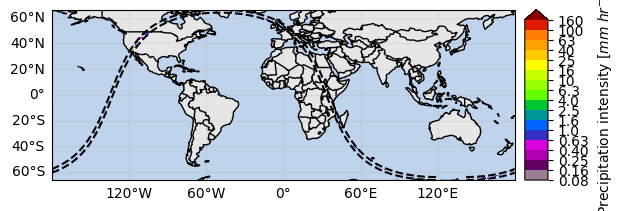

In [22]:
ds[variable].gpm.plot_map()

By focusing on a narrow region, it's possible to better visualize the spatial field:

Text(0.5, 1.0, '2A-DPR PrecipRateNearSurface')

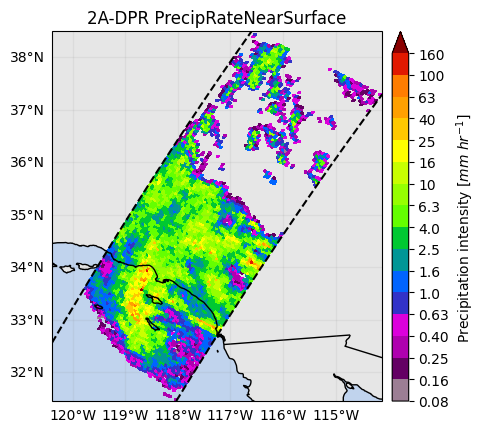

In [23]:
p = ds[variable].gpm.sel(gpm_id=slice(start_gpm_id, end_gpm_id)).gpm.plot_map()
p.axes.set_title(ds[variable].gpm.title(add_timestep=False))

Using the `gpm.plot_image` method is possible to visualize the data in the so-called "swath scan view":

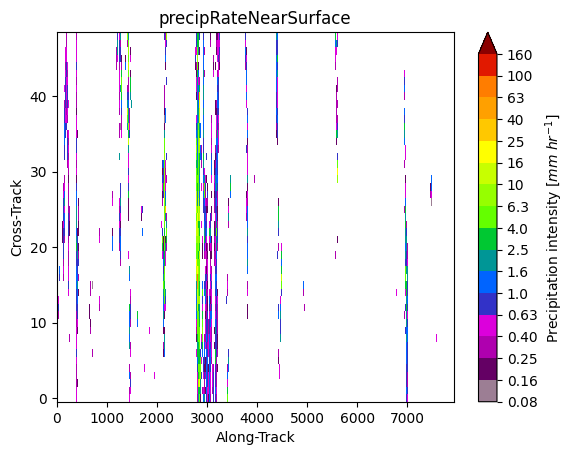

In [24]:
ds[variable].gpm.plot_image()

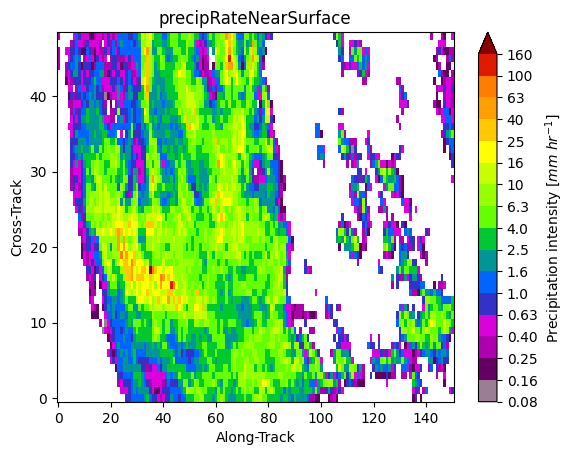

In [25]:
ds[variable].gpm.sel(gpm_id=slice(start_gpm_id, end_gpm_id)).gpm.plot_image()

When we visualize different product variables, GPM-API will automatically try to use different appropriate colormaps and colorbars. 
You can observe this in the following example:

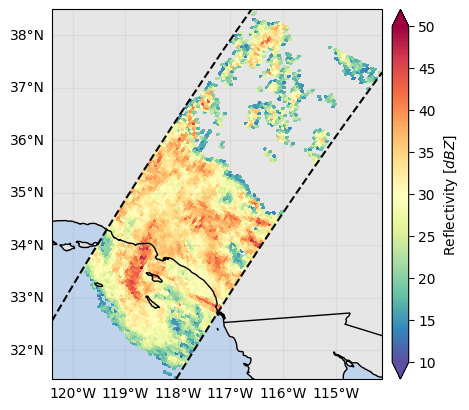

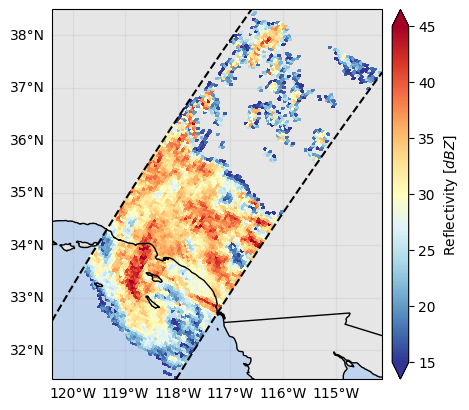

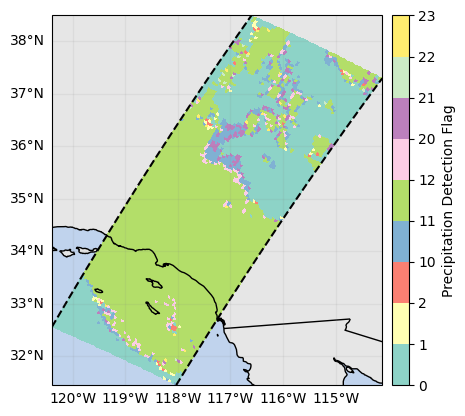

In [26]:
ds_subset = ds.gpm.sel(gpm_id=slice(start_gpm_id, end_gpm_id), radar_frequency="Ku")
p = ds_subset["zFactorFinalNearSurface"].gpm.plot_map()
p = ds_subset["zFactorFinalNearSurface"].gpm.plot_map(cmap="RdYlBu_r", vmin=15, vmax=45) # ex: enable to modify defaults parameters on the fly
p = ds_subset["flagPrecip"].gpm.plot_map() # ex: defaults to categorical colorbar

GPM-API provides colormaps and colorbars tailored to GPM product variables with the goal of simplifying the data analysis and make it more reproducible.

The default colormap and colorbar configurations are defined into YAML files into the [gpm/etc/colorbars directory](https://github.com/ghiggi/gpm_api/blob/main/gpm/etc/colorbars/) of the software.

However, users are free to override, add and/or customize the colorbars configurations using the pycolorbar (https://pycolorbar.readthedocs.io/en/latest/index.html) registry.

The registered colorbar configurations can be displayed using `gpm.colorbars.show_colorbars()` and the `plot_kwargs` and `cbar_kwargs` required to customize the figure can be obtained by calling the `gpm.get_plot_kwargs` function. Here below we provide an example on how to display DPR precipitation rates estimates using the same colorbar used by NASA to display IMERG liquid precipitation estimates.

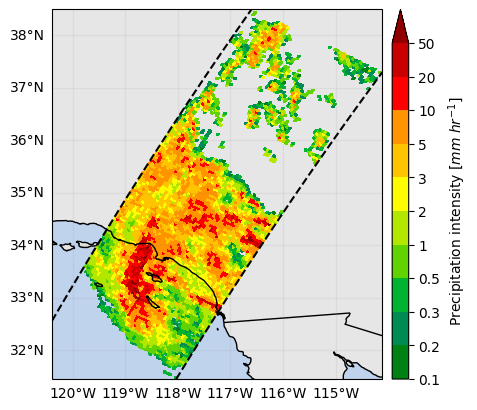

In [27]:
plot_kwargs, cbar_kwargs = gpm.get_plot_kwargs("IMERG_Liquid")
ds_subset["precipRateNearSurface"].gpm.plot_map(cbar_kwargs=cbar_kwargs, **plot_kwargs)

Since GPM Datasets are characterized by multiple dimensions, GPM-API provides the capabilities to generate FacetGrid Cartopy plots following the classical xarray syntax: 

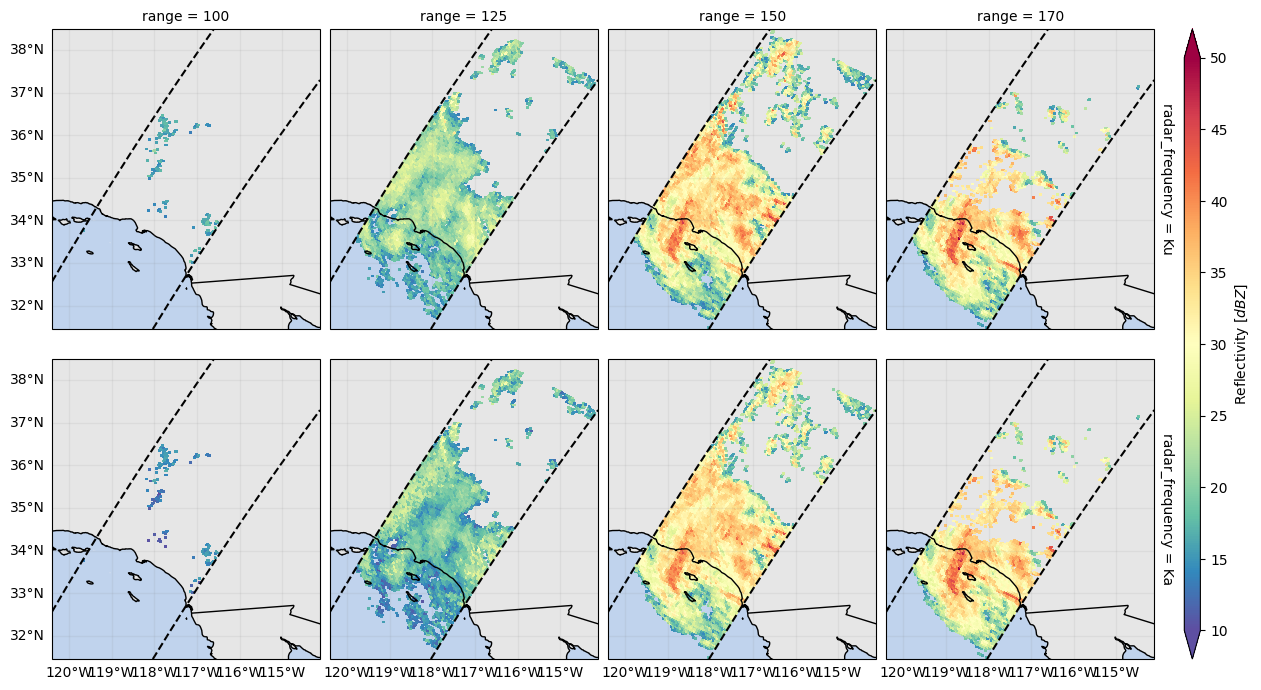

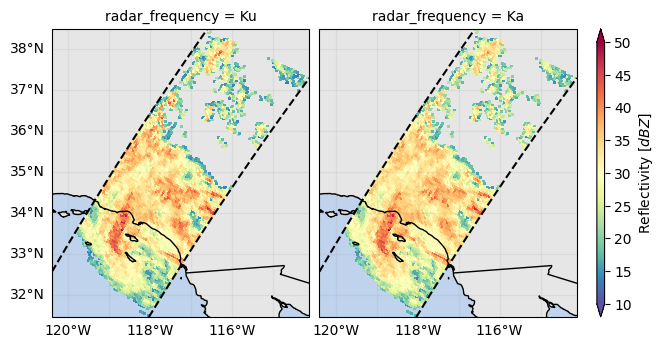

In [28]:
ds_subset = ds.gpm.sel(gpm_id=slice(start_gpm_id, end_gpm_id))

# Plot reflectivity at various levels 
variable = "zFactorFinal"
da = ds_subset[variable].sel(range=[100, 125, 150, 170])
fc = da.gpm.plot_map(row="radar_frequency", col="range")

# Surface reflectivity at Ku and Ka band
variable = "zFactorFinalNearSurface"
da = ds_subset[variable]
fc = da.gpm.plot_map(col="radar_frequency", col_wrap=2)

## 5. Plot Cross-Sections

An easy way to derive a vertical cross-section is to slice the data along the cross-track or along-track dimension.
We can then plot the cross-section calling the `gpm.plot_transect()` method.

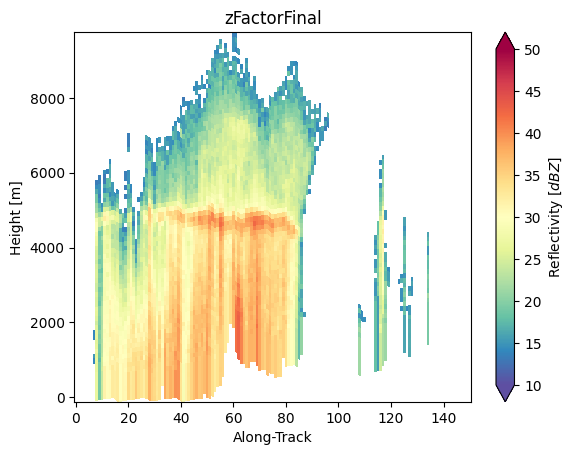

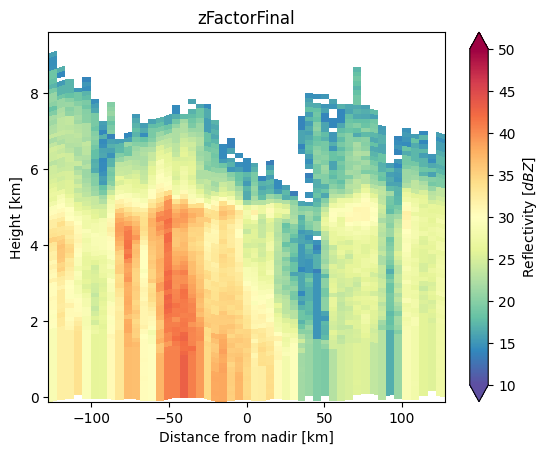

In [29]:
ds_subset = ds.gpm.sel(gpm_id=slice(start_gpm_id, end_gpm_id), radar_frequency="Ku")
ds_subset["zFactorFinal"].isel(cross_track=24).gpm.plot_transect(zoom=True)
ds_subset["zFactorFinal"].isel(along_track=30).gpm.plot_transect(y="height_km", x="horizontal_distance_km", zoom=True)

However, GPM-API also provides accessor methods to facilitate the extraction of cross-section around a point, between points and along a trajectory.
Here below we provide some examples:

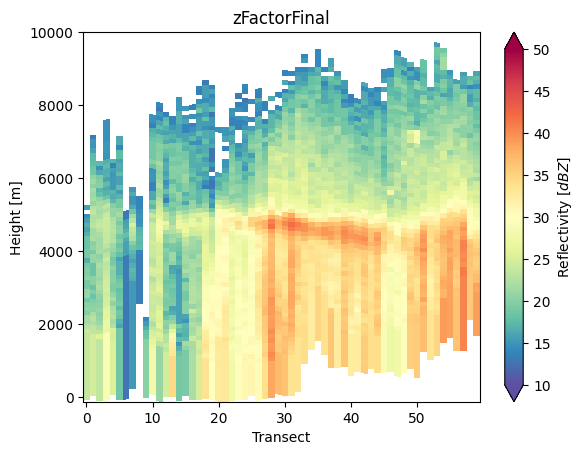

In [30]:
da_cross = ds_subset["zFactorFinal"].gpm.extract_transect_between_points(start_point=(-118, 32), end_point=(-118, 36), steps=60)      
da_cross.gpm.plot_transect(zoom=True)

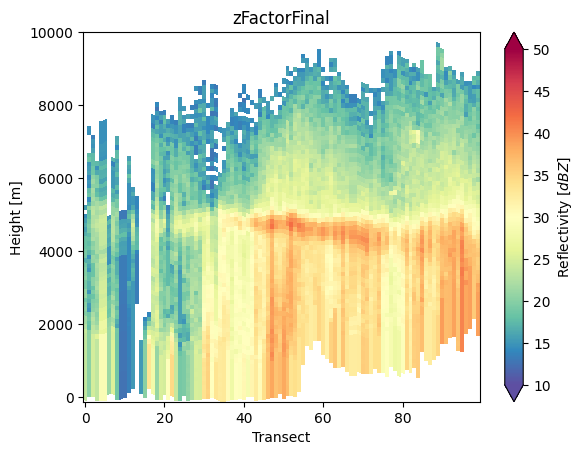

In [31]:
points = np.ones((100, 2)) 
points[:,0] = -118               
points[:,1] = np.linspace(32, 36, 100)            
da_cross = ds_subset["zFactorFinal"].gpm.extract_transect_along_trajectory(points=points)    
da_cross.gpm.plot_transect(zoom=True)

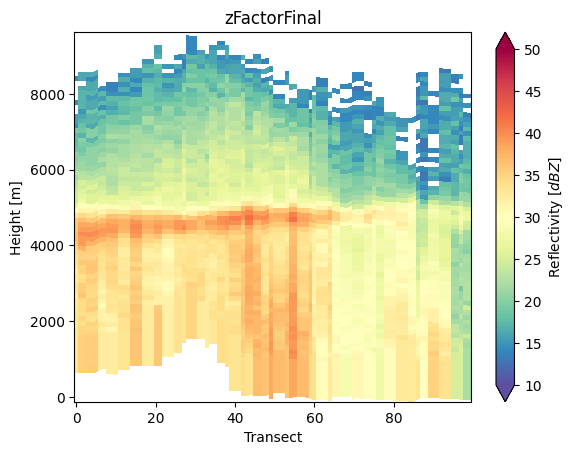

In [32]:
da_cross = ds_subset["zFactorFinal"].gpm.extract_transect_around_point(point=(-118, 34), azimuth=0, distance=100_000, steps=100) # azimuth [0, 360]
da_cross.gpm.plot_transect(zoom=True)

## 6. Community-based retrievals

GPM-API aims to be a platform where scientist can share their algorithms and retrievals with the community.

Based on the GPM product you are working with, you will have a series of retrievals available to you.
For example, GPM-API currently provide the following retrievals for the 2A-DPR product:

In [33]:
ds.gpm.available_retrievals()

['EchoDepth',
 'EchoTopHeight',
 'HailKineticEnergy',
 'MESH',
 'MESHS',
 'POH',
 'POSH',
 'REFC',
 'REFCH',
 'SHI',
 'VIL',
 'VILD',
 'bright_band_ratio',
 'c_band_tan',
 'dfrFinal',
 'dfrFinalNearSurface',
 'dfrMeasured',
 'flagHydroClass',
 'flagPrecipitationType',
 'gate_resolution',
 'gate_volume',
 'heightClutterFreeBottom',
 'heightRealSurfaceKa',
 'heightRealSurfaceKu',
 'range_distance_from_ellipsoid',
 'range_distance_from_satellite',
 'range_resolution',
 's_band_cao2013',
 'x_band_tan']

The `gpm.retrieve` method enables you to apply specific retrievals to your dataset.
Here below we provide a couple of examples: 

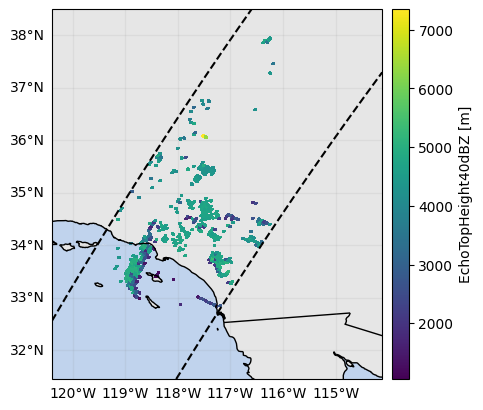

In [34]:
ds_subset = ds.gpm.sel(gpm_id=slice(start_gpm_id, end_gpm_id), radar_frequency="Ku")

ds_subset["EchoTopHeight40dBZ"] = ds_subset.gpm.retrieve("EchoTopHeight", threshold=40)
ds_subset["EchoTopHeight40dBZ"].gpm.plot_map()

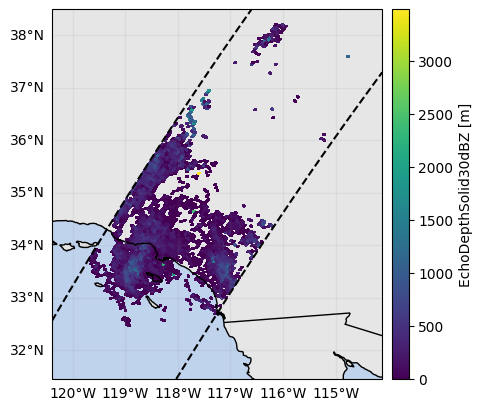

In [35]:
ds_subset["EchoDepthSolid30dBZ"] = ds_subset.gpm.retrieve("EchoDepth", threshold=30, mask_liquid_phase=True)
ds_subset["EchoDepthSolid30dBZ"].gpm.plot_map()


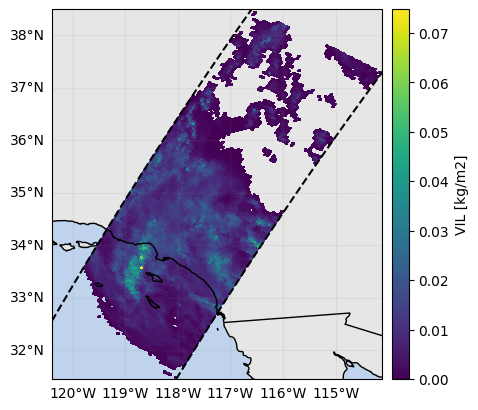

In [36]:
ds_subset["VIL"] = ds_subset.gpm.retrieve("VIL")
ds_subset["VIL"].gpm.plot_map()

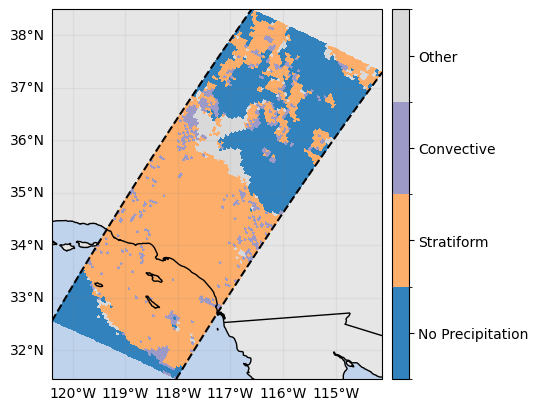

In [37]:
ds_subset["flagPrecipitationType"] = ds_subset.gpm.retrieve("flagPrecipitationType", method="major_rain_type")
ds_subset["flagPrecipitationType"].gpm.plot_map()


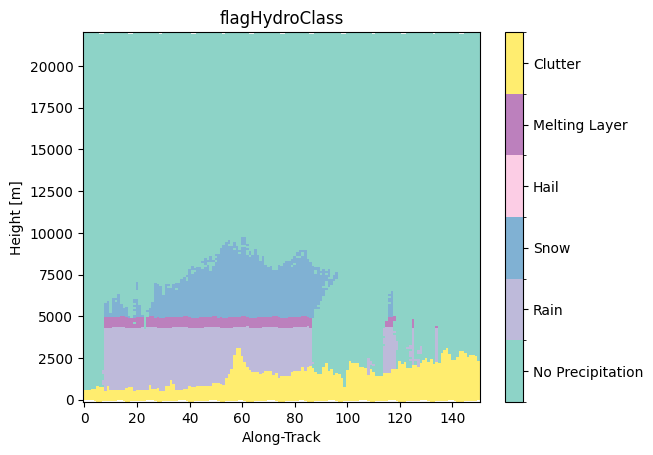

In [38]:
ds_subset["flagHydroClass"] = ds_subset.gpm.retrieve("flagHydroClass") # this return a 3D array !
ds_subset["flagHydroClass"].isel(cross_track=24).gpm.plot_transect()

## 7. Advanced Manipulations 

When working with spaceborne radar data, it is often necessary to slice, extract or mask portions of data across the `range` dimension. 
The xarray `gpm` accessor provides a series of methods to facilitate various tasks.

If you wish to extract the values at specific range gate position varying over each radar beam, you can use the `slice_range_at_bin` method. 
For example, to extract values near the surface where radar gates are not more contaminated by ground clutter, you can use the bin variable `"binClutterFreeBottom"`:

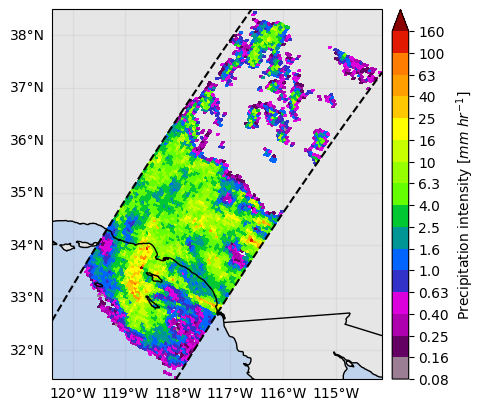

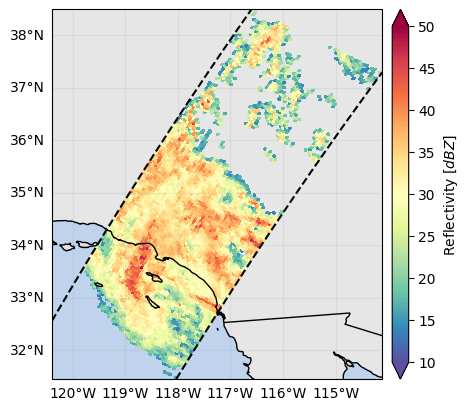

In [39]:
ds_surface = ds_subset.gpm.slice_range_at_bin(bins="binClutterFreeBottom") # or ds.gpm.slice_range_at_bin(bins=ds["binClutterFreeBottom"])
ds_surface["precipRate"].gpm.plot_map()  # precipRate is originally a 3D variable !
ds_surface["zFactorFinal"].gpm.plot_map()  # zFactorFinal is originally a 3D variable !

Other slicing methods provide capabilities to retrieve values at a given height, along isothermals, or at the range gates where the minimum, maximum or closest value of a given variable occur:

In [40]:
ds_isothermal = ds_subset.gpm.slice_range_at_temperature(273.15)  # use by default the airTemperature variable 
ds_3000 = ds_subset.gpm.slice_range_at_height(3000) 
ds_max_z = ds_subset.gpm.slice_range_at_max_value(variable="zFactorFinal")  
ds_min_z = ds_subset.gpm.slice_range_at_min_value(variable="zFactorFinal")
ds_at_z_30 = ds_subset.gpm.slice_range_at_value(variable="zFactorFinal", value=30)

If you want to focus your analysis in the portion of radar gates with valid values (e.g., excluding upper atmosphere regions without reflectivities) or values ranging in a specific interval of interest, you can use the `subset_range_with_valid_data` and `subset_range_where_values` methods respectively:

In [42]:
ds_valid = ds_subset.gpm.subset_range_with_valid_data(variable="zFactorFinal")  
ds_intense = ds_subset.gpm.subset_range_where_values(variable="precipRate", vmin=200, vmax=300) # mm/hr
print(ds_valid["range"].data)
print(ds_intense["range"].data)

[ 93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176]
[166 167 168 169 170 171 172 173 174 175 176]


If you wish to extract radar gates above/below spatially-varying bin position, you can use the `extract_dataset_above_bin` and `extract_dataset_below_bin` methods. 
Please note that these methods shifts the arrays beam-wise, returning datasets with a new `range` coordinate and the bin variables updated accordingly.

In [43]:
ds_below_melting_layer = ds_subset.gpm.extract_dataset_below_bin("binBBBottom") # the first new range index corresponds to original binBBBottom
ds_above_melting_layer = ds_subset.gpm.extract_dataset_above_bin("binBBTop")    # the last new range index corresponds to original binBBTop

/home/ghiggi/micromamba/envs/gpm-api-dev/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


If instead you wish to mask the data above/below or in between radar gates positions, you can use the `mask_above_bin`, `mask_below_bin` and `mask_between_bins` methods:

In [44]:
 ds_rain = ds_subset.gpm.mask_above_bin('binZeroDeg')  
 ds_snow = ds_subset.gpm.mask_below_bin('binZeroDeg')  
 ds_masked_melting_layer = ds_subset.gpm.mask_between_bins(bottom_bins="binBBBottom", top_bins="binBBTop")

## 8. Geospatial Manipulations

GPM-API provides methods to easily spatially subset orbits by extent, country or continent.

Note however, that an area can be crossed by multiple orbits depending on the size of your GPM satellite dataset. 
In other words, multiple orbit slices in along-track direction can intersect the area of interest. 

The method `get_crop_slices_by_extent`, `get_crop_slices_by_country` and ` get_crop_slices_by_continent` enable to retrieve the orbit portions intersecting the area of interest. 

[{'along_track': slice(2426, 3805, None)}]
[{'along_track': slice(2426, 3805, None)}]


/home/ghiggi/micromamba/envs/gpm-api-dev/lib/python3.11/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.datetime_as_string` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


[{'along_track': slice(2751, 2852, None)}]
[{'along_track': slice(2751, 2852, None)}]


/home/ghiggi/micromamba/envs/gpm-api-dev/lib/python3.11/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.datetime_as_string` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


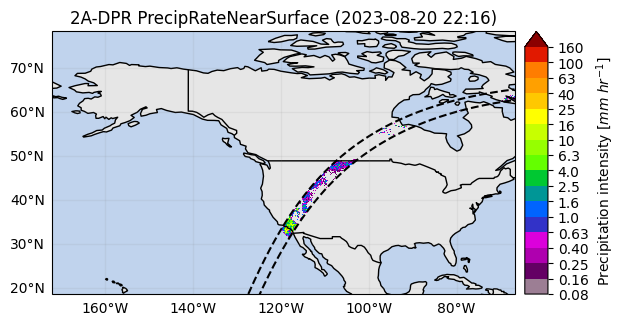

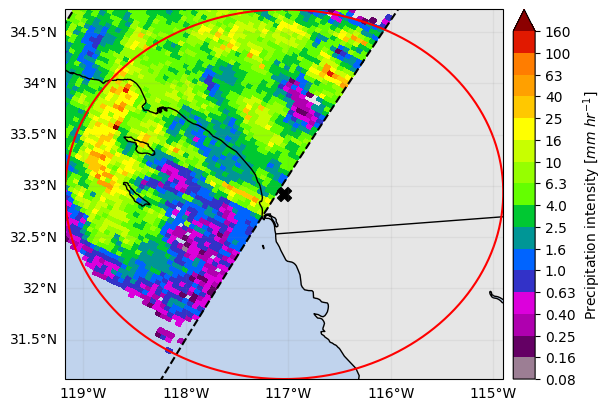

In [45]:
# Define the variable to display
variable = "precipRateNearSurface"

# Crop by country
list_isel_dict = ds.gpm.get_crop_slices_by_country("United States")
print(list_isel_dict)

# Crop by extent  
extent = get_country_extent("United States")
list_isel_dict = ds.gpm.get_crop_slices_by_extent(extent)
print(list_isel_dict)

# Plot the swaths crossing the country
for isel_dict in list_isel_dict:
    da_subset = ds[variable].isel(isel_dict)
    slice_title = da_subset.gpm.title(add_timestep=True)
    p = da_subset.gpm.plot_map()
    p.axes.set_extent(extent)
    p.axes.set_title(label=slice_title)

# Define the variable to display
variable = "precipRateNearSurface"

# Crop around a point (i.e. radar location)
lon = -117.0418
lat = 32.9190
distance = 200_000 # 200 km 
list_isel_dict = ds.gpm.get_crop_slices_around_point(lon=lon, lat=lat, distance=distance)
print(list_isel_dict)

extent = get_geographic_extent_around_point(lon=lon, lat=lat, distance=distance)
list_isel_dict = ds.gpm.get_crop_slices_by_extent(extent)
print(list_isel_dict)

# Define ROI coordinates
circle_lons, circle_lats = get_circle_coordinates_around_point(lon, lat, radius=distance, num_vertices=360)

# Plot the swaths crossing the ROI
for isel_dict in list_isel_dict:
    da_subset = ds[variable].isel(isel_dict)
    slice_title = da_subset.gpm.title(add_timestep=True)
    p = da_subset.gpm.plot_map()
    p.axes.plot(circle_lons, circle_lats, 'r-', transform=ccrs.Geodetic())
    p.axes.scatter(lon, lat, c="black", marker="X", s=100, transform=ccrs.Geodetic()) 
    p.axes.set_extent(extent)

# Alternatives if working with a single granule: 

# ds_subset = ds.gpm.crop_by_extent(extent)
# ds_subset = ds.gpm.crop_by_country("United States")

You can also easily obtain the extent around a given point (i.e. ground radar location) using the `get_geographic_extent_around_point` function and use 
the gpm accessor methods `get_crop_slices_around_point` or `crop_around_point` to subset your dataset:

[{'along_track': slice(2751, 2852, None)}]
[{'along_track': slice(2751, 2852, None)}]


/home/ghiggi/micromamba/envs/gpm-api-dev/lib/python3.11/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.datetime_as_string` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


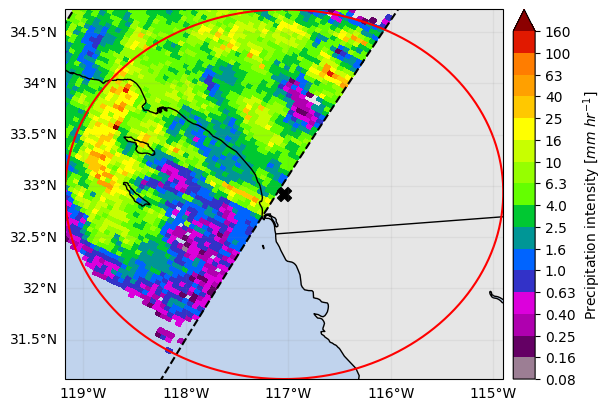

In [46]:
# Define the variable to display
variable = "precipRateNearSurface"

# Crop around a point (i.e. radar location)
lon = -117.0418
lat = 32.9190
distance = 200_000 # 200 km 
list_isel_dict = ds.gpm.get_crop_slices_around_point(lon=lon, lat=lat, distance=distance)
print(list_isel_dict)

extent = get_geographic_extent_around_point(lon=lon, lat=lat, distance=distance)
list_isel_dict = ds.gpm.get_crop_slices_by_extent(extent)
print(list_isel_dict)

# Define ROI coordinates
circle_lons, circle_lats = get_circle_coordinates_around_point(lon, lat, radius=distance, num_vertices=360)

# Plot the swaths crossing the ROI
for isel_dict in list_isel_dict:
    da_subset = ds[variable].isel(isel_dict)
    slice_title = da_subset.gpm.title(add_timestep=True)
    p = da_subset.gpm.plot_map()
    p.axes.plot(circle_lons, circle_lats, 'r-', transform=ccrs.Geodetic())
    p.axes.scatter(lon, lat, c="black", marker="X", s=100, transform=ccrs.Geodetic()) 
    p.axes.set_extent(extent)

# Alternatives if working with a single granule: 

# ds_subset = ds.gpm.crop_around_point(lon=lon, lat=lat, distance=distance)

Please keep in mind that you can easily retrieve the extent of a GPM xarray object using the `extent` method. 

The optional argument `padding` allows to expand/shrink the geographic extent by custom lon/lat degrees, while the `size` argument allows 
to obtain an extent centered on the GPM object with the desired size.

In [47]:
print(da_subset.gpm.extent(padding=0.1)) # expanding
print(da_subset.gpm.extent(padding=-0.1)) # shrinking
print(da_subset.gpm.extent(size=0.5))
print(da_subset.gpm.extent(size=0)) # centroid

Extent(xmin=-120.85270843505859, xmax=-115.86820831298829, ymin=30.720465087890624, ymax=35.94685516357422)
Extent(xmin=-120.6527084350586, xmax=-116.06820831298828, ymin=30.920465087890626, ymax=35.74685516357422)
Extent(xmin=-118.61045837402344, xmax=-118.11045837402344, ymin=33.08366012573242, ymax=33.58366012573242)
Extent(xmin=-118.36045837402344, xmax=-118.36045837402344, ymin=33.33366012573242, ymax=33.33366012573242)


## 9. Storm Labeling


 

Using the xarray `ximage` accessor, it is possible to easily delineate (label) the precipitating areas. The label array is added to the dataset as a new coordinate.

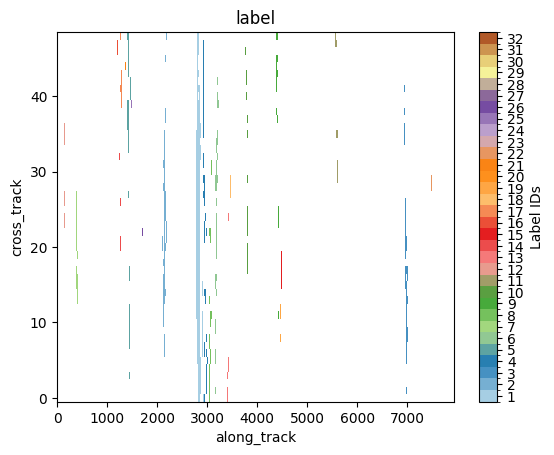

In [48]:
# Retrieve labeled xarray object
label_name = "label"
ds = ds.ximage.label(
    variable="precipRateNearSurface", 
    min_value_threshold=1,
    min_area_threshold=5,
    footprint=5, # assign same label to precipitating areas 5 pixels apart
    sort_by="area", # "maximum", "minimum", <custom_function>
    sort_decreasing=True,
    label_name=label_name,
)
# Plot full label array
ds[label_name].ximage.plot_labels()

Let's zoom in a specific region:

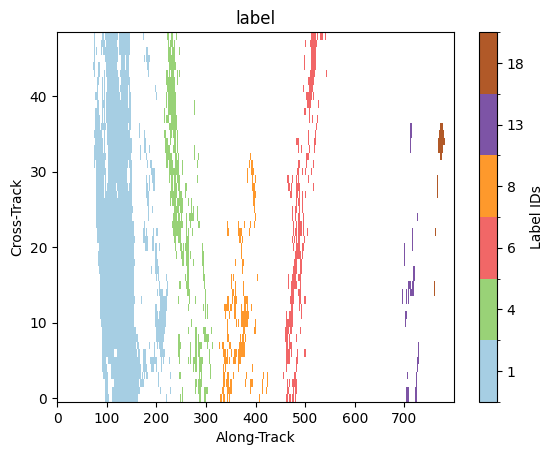

In [49]:
gpm.plot_labels(ds[label_name].isel(along_track=slice(2700, 3500)))

## 10. Patch Extraction

With the xarray `ximage` accessor, it is also possible to extract patches around the precipitating areas. Here we provide a minimal example on how to proceed:

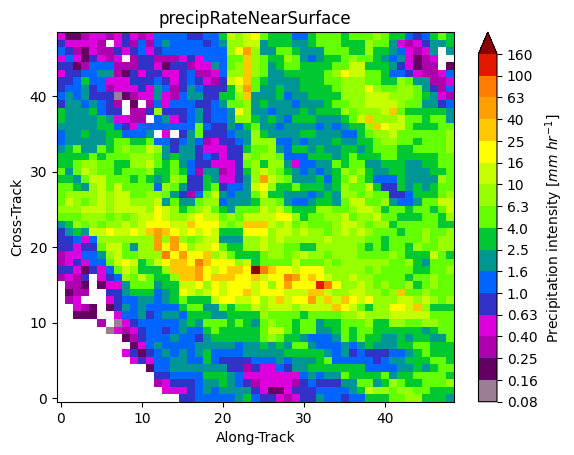

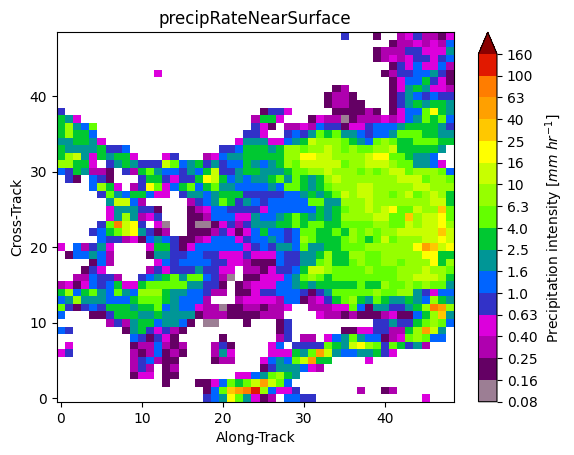

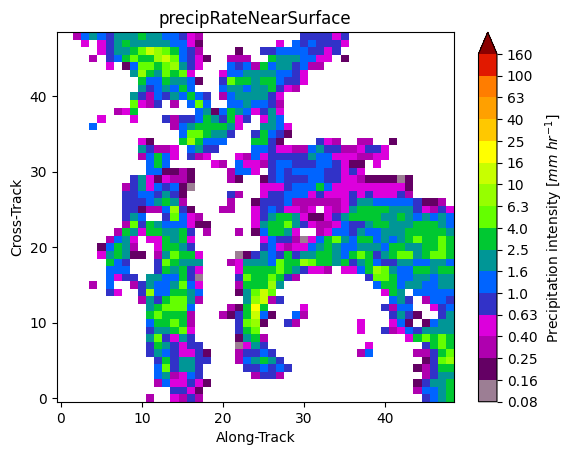

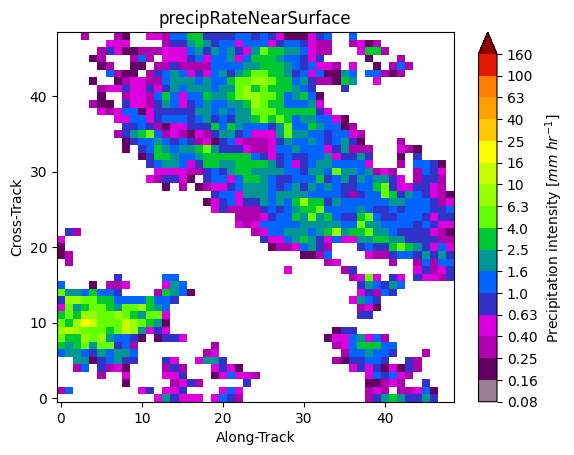

In [50]:
# Define the patch generator
da_patch_gen = ds["precipRateNearSurface"].ximage.label_patches(
    label_name=label_name,
    patch_size=(49, 49),
    variable=variable,
    # Output options
    n_patches=4,
    # Patch extraction Options
    padding=0,
    centered_on="max",
    # Tiling/Sliding Options
    debug=False, 
    verbose=False,
)

# # Retrieve list of patches
list_label_patches = list(da_patch_gen)
list_da = [da for label, da in list_label_patches]

# Display patches 
gpm.plot_patches(list_label_patches)

You can exploit the xarray manipulations and FacetGrid capabilities to quickly create the following figure:

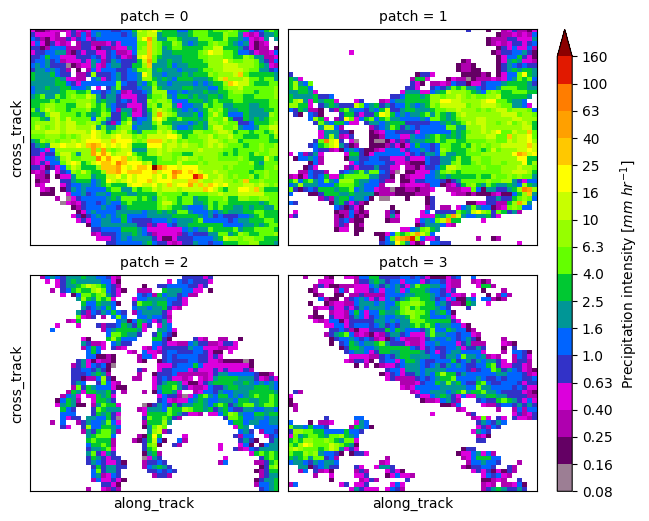

In [51]:
list_da_without_coords = [da.drop_vars(["lon","lat"]) for da in list_da]
da_patch = xr.concat(list_da_without_coords, dim="patch")
da_patch.isel(patch=slice(0,4)).gpm.plot_image(col="patch", col_wrap=2) 

## 11. Spaceborne/Ground Radar Matching

In this final subsection, we now provide also brief overview on how to match spaceborne (SR) and ground (GR) radar measurements. 

A step-by-step guide on the methodology to obtain spatially and temporally coincident radar samples is provided in 
the [Spaceborne-Ground Radar Matching Tutorial](https://gpm-api.readthedocs.io/en/latest/tutorials/tutorial_03_SR_GR_Matching.html), 
while an applied example is provided in the [Spaceborne-Ground Radar Calibration Applied Tutorial](https://gpm-api.readthedocs.io/en/latest/tutorials/tutorial_03_SR_GR_Calibration.html).

To start let's open the NEXRAD ground radar data coincident with the GPM DPR overpass. We have preprocessed the native NEXRAD radar with xradar and uploaded it into Zarr format on the Pythia Cloud Bucket.

In [52]:
filepath_gr = "/home/ghiggi/data/bucket/KNKX20230820_221341_V06.zarr"
dt_gr =  open_datatree(filepath_gr, engine="zarr", chunks={})
display(dt_gr)

<xarray.DataTree>
Group: /
│   Dimensions:              ()
│   Data variables:
│       altitude             int64 8B ...
│       instrument_type      <U5 20B ...
│       latitude             float64 8B ...
│       longitude            float64 8B ...
│       platform_type        <U5 20B ...
│       time_coverage_end    <U20 80B ...
│       time_coverage_start  <U20 80B ...
│       volume_number        int64 8B ...
│   Attributes:
│       Conventions:      None
│       comment:          im/exported using xradar
│       history:          None
│       institution:      None
│       instrument_name:  KNKX
│       references:       None
│       source:           None
│       title:            None
│       version:          None
├── Group: /sweep_0
│       Dimensions:            (azimuth: 720, range: 1832)
│       Coordinates:
│           altitude           int64 8B ...
│         * azimuth            (azimuth) float64 6kB 0.2499 0.7471 1.261 ... 359.2 359.8
│           elevation          (azimuth) float64 6kB dask.array<chunksize=(720,), meta=np.ndarray>
│           latitude           float64 8B ...
│           longitude          float64 8B ...
│         * range              (range) float32 7kB 2.125e+03 2.375e+03 ... 4.599e+05
│           time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
│       Data variables:
│           CCORH              (azimuth, range) float64 11MB dask.array<chunksize=(360, 916), meta=np.ndarray>
│           DBZH               (azimuth, range) float64 11MB dask.array<chunksize=(360, 916), meta=np.ndarray>
│           PHIDP              (azimuth, range) float64 11MB dask.array<chunksize=(180, 916), meta=np.ndarray>
│           RHOHV              (azimuth, range) float64 11MB dask.array<chunksize=(360, 916), meta=np.ndarray>
│           ZDR                (azimuth, range) float64 11MB dask.array<chunksize=(360, 916), meta=np.ndarray>
│           follow_mode        <U7 28B ...
│           prt_mode           <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│       Attributes:
│           instrument_name:  KNKX
├── Group: /sweep_1
│       Dimensions:            (azimuth: 720, range: 1192)
│       Coordinates:
│           altitude           int64 8B ...
│         * azimuth            (azimuth) float64 6kB 0.217 0.7086 1.189 ... 359.2 359.7
│           elevation          (azimuth) float64 6kB dask.array<chunksize=(720,), meta=np.ndarray>
│           latitude           float64 8B ...
│           longitude          float64 8B ...
│         * range              (range) float32 5kB 2.125e+03 2.375e+03 ... 2.999e+05
│           time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
│       Data variables:
│           DBZH               (azimuth, range) float64 7MB dask.array<chunksize=(360, 596), meta=np.ndarray>
│           VRADH              (azimuth, range) float64 7MB dask.array<chunksize=(360, 596), meta=np.ndarray>
│           WRADH              (azimuth, range) float64 7MB dask.array<chunksize=(360, 596), meta=np.ndarray>
│           follow_mode        <U7 28B ...
│           prt_mode           <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│       Attributes:
│           instrument_name:  KNKX
├── Group: /sweep_10
│       Dimensions:            (azimuth: 360, range: 1336)
│       Coordinates:
│           altitude           int64 8B ...
│         * azimuth            (azimuth) float64 3kB 0.5823 1.571 2.59 ... 358.6 359.6
│           elevation          (azimuth) float64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
│           latitude           float64 8B ...
│           longitude          float64 8B ...
│         * range              (range) float32 5kB 2.125e+03 2.375e+03 ... 3.359e+05
│           time               (azimuth) datetim

Now, let’s select the GR sweep to match with GPM DPR.

In [53]:
sweep_idx = 0
sweep_group = f"sweep_{sweep_idx}"  # GR sweep (elevation to be used)
ds_gr = dt_gr[sweep_group].ds

Let's define some SR/GR volume matching settings ...

In [54]:
radar_band = "S"
beamwidth_gr = 1
z_min_threshold_gr = 0
z_min_threshold_sr = 10

... and then apply the SR/GR volume matching. If the GPM Dataset is not specified, `volume_matching` automatically download and load the required SR radar data.

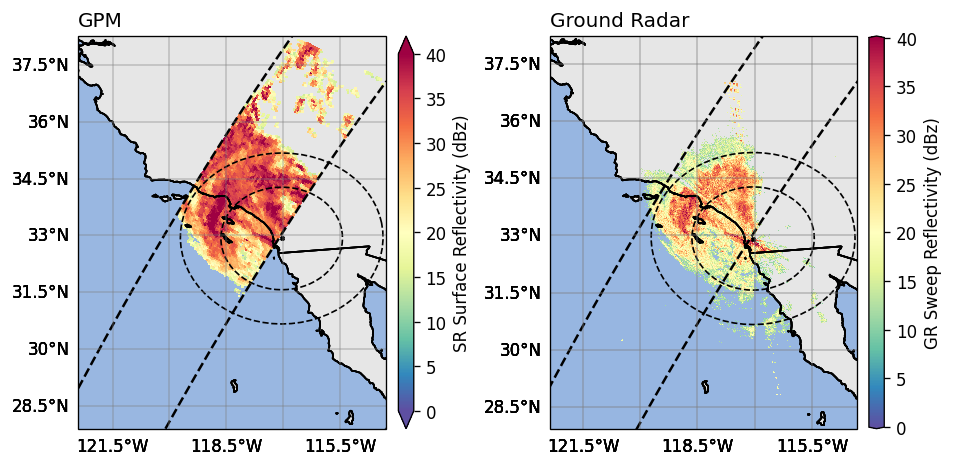

SR/GR Matching Elapsed time: 0:00:36.549211 .


GR_Z_mean  GR_Z_std  GR_Z_max  GR_Z_min  GR_Z_range  GR_Z_cov  \
0     15.221830  2.218835      19.5      10.5         9.0  0.145767   
1     13.581805  1.941147      18.5      10.0         8.5  0.142923   
2     16.550807  3.090479      23.0      10.0        13.0  0.186727   
3     19.808129  3.660031      26.0      11.0        15.0  0.184774   
4     18.983302  3.406269      24.5      10.0        14.5  0.179435   
...         ...       ...       ...       ...         ...       ...   
1300        NaN       NaN       NaN       NaN         NaN       NaN   
1301        NaN       NaN       NaN       NaN         NaN       NaN   
1302        NaN       NaN       NaN       NaN         NaN       NaN   
1303        NaN       NaN       NaN       NaN         NaN       NaN   
1304        NaN       NaN       NaN       NaN         NaN       NaN   

                           GR_time  GR_gate_volume_sum  \
0    2023-08-20 22:13:43.619000064        1.325220e+09   
1    2023-08-20 22:13:43.513999872        1.316104e+09   
2    2023-08-20 22:13:43.414000128        1.304555e+09   
3    2023-08-20 22:13:43.315000064        1.292233e+09   
4    2023-08-20 22:13:43.212000000        1.280453e+09   
...                            ...                 ...   
1300 2023-08-20 22:13:51.476000000                 NaN   
1301 2023-08-20 22:13:51.652999936                 NaN   
1302 2023-08-20 22:13:51.756000000                 NaN   
1303 2023-08-20 22:13:51.886000128                 NaN   
1304 2023-08-20 22:13:51.857999872                 NaN   

      GR_fraction_covered_area  GR_counts  ...  sweep_number along_track  \
0                     0.523921       50.0  ...             0          98   
1                     0.792108       73.0  ...             0          98   
2                     0.966467       92.0  ...             0          98   
3                     1.000000       98.0  ...             0          98   
4                     1.000000       98.0  ...             0          98   
...                        ...        ...  ...           ...         ...   
1300                  0.994502       96.0  ...             0         157   
1301                  1.000000       99.0  ...             0         157   
1302                  1.000000       99.0  ...             0         157   
1303                  1.000000      104.0  ...             0         157   
1304                  0.606705       59.0  ...             0         158   

      cross_track  VolumeRatio    VolumeDiff           time_difference  \
0              42    44.668064  5.786978e+10 0 days 00:01:37.619000064   
1              43    47.688195  6.144654e+10 0 days 00:01:37.513999872   
2              44    46.511517  5.937226e+10 0 days 00:01:37.414000128   
3              45    47.599161  6.021699e+10 0 days 00:01:37.315000064   
4              46    48.697237  6.107406e+10    0 days 00:01:37.212000   
...           ...          ...           ...                       ...   
1300           45          NaN           NaN    0 days 00:01:04.476000   
1301           46          NaN           NaN 0 days 00:01:04.652999936   
1302           47          NaN           NaN    0 days 00:01:04.756000   
1303           48          NaN           NaN 0 days 00:01:04.886000128   
1304           48          NaN           NaN 0 days 00:01:03.857999872   

      GR_z_lower_bound  GR_z_upper_bound  SR_z_lower_bound  SR_z_upper_bound  
0          1535.796701       4204.951593       1654.094116       4209.583984  
1          1514.601481       4200.459785       1558.925415       4227.430664  
2          1494.739411       4194.752350       1605.041138       4143.421875  
3          1475.392380       4182.133888       1527.083740       4056.250488  
4          1468.574285       4156.773245       1571.319336       4090.862549  
...                ...               ...               ...               ...  
1300               NaN               NaN       1537.145386       4186.728516  
1301               NaN

In [55]:
gdf_match = volume_matching(
    ds_gr=ds_gr,
    ds_sr=ds, # optional
    radar_band=radar_band,
    beamwidth_gr=beamwidth_gr,
    z_min_threshold_gr=z_min_threshold_gr,
    z_min_threshold_sr=z_min_threshold_sr,
    min_gr_range=0,
    max_gr_range=150_000,
    # gr_sensitivity_thresholds=None,
    # sr_sensitivity_thresholds=None,
    download_sr=False,  # require NASA accounts and internet connection !
    display_quicklook=True,
)
display(gdf_match)

Now let's display the SR/GR matched/aggregated reflectivities:

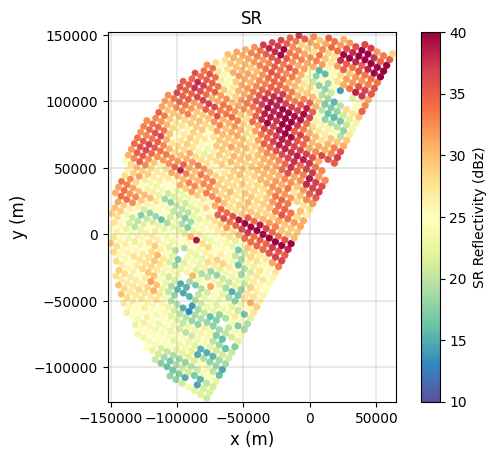

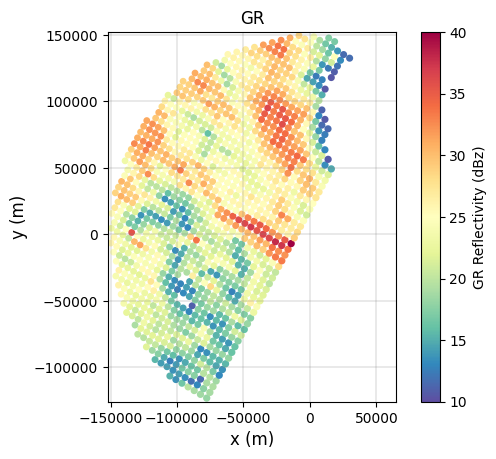

In [56]:
extent_xy = gdf_match.total_bounds[[0, 2, 1, 3]]
p = gdf_match.plot(
    column=f"SR_zFactorFinal_{radar_band}_mean",
    legend=True,
    legend_kwds={"label": "SR Reflectivity (dBz)"},
    cmap="Spectral_r",
    vmin=10,
    vmax=40,
)
p.axes.set_xlim(extent_xy[0:2])
p.axes.set_ylim(extent_xy[2:4])
p.axes.set_title("SR")
plt.xlabel("x (m)", fontsize=12)
plt.ylabel("y (m)", fontsize=12)
plt.grid(lw=0.25, color="grey")

p = gdf_match.plot(
    column="GR_Z_mean",
    legend=True,
    legend_kwds={"label": "GR Reflectivity (dBz)"},
    cmap="Spectral_r",
    vmin=10,
    vmax=40,
)
p.axes.set_xlim(extent_xy[0:2])
p.axes.set_ylim(extent_xy[2:4])
p.axes.set_title("GR")
plt.xlabel("x (m)", fontsize=12)
plt.ylabel("y (m)", fontsize=12)
plt.grid(lw=0.25, color="grey")